# Versionamento

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, plot_confusion_matrix
import datetime

# Load Data

In [2]:
pwbdatafile = '..\\data\\pwb-validation.csv'    # 3 breaks
# pwbdatafile = '..\\data\\pwb-validation-b1-b3.csv'    # 2 breaks
# pwbdatafile = '..\\data\\pwb-validation-b1.csv'    # 1 break
pwbds = pd.read_csv(pwbdatafile)
pwbds['time']= pd.to_datetime(pwbds['time'])

In [3]:
pwbds['y'].value_counts()

0    706
1      3
Name: y, dtype: int64

## Cálculo do Remaining Usefull Lifecycle (RUL)

In [4]:
# Dates whith break
df_sub = sorted(pwbds[pwbds['y'] == 1]['time'].tolist())

In [5]:
# variable to store all days
breakSubIdx=0
breakLstIdx=0
breakList = pwbds['y'].tolist()
nextbreak = []
for v1 in pwbds['time'].tolist():
    if((breakList[breakLstIdx] == 1)):
#        print ('1')
        nextbreak.append(v1)
        breakSubIdx = breakSubIdx+1
    else:
#        print('0')
        if (breakSubIdx < len(df_sub)):
            nextbreak.append(df_sub[breakSubIdx])
        else:
            nextbreak.append(df_sub[breakSubIdx-1])
    breakLstIdx = breakLstIdx+1
pwbds['nextbreaktime'] = pd.Series(nextbreak)

In [6]:
pwbds['RUL']=round((pwbds['nextbreaktime']-pwbds['time']).dt.total_seconds()/60,2)
pwbds.drop(pwbds[pwbds.RUL < 0].index, inplace=True)
pwbds.drop(['time','nextbreaktime'], axis=1, inplace=True)

In [51]:
pwbds[pwbds.y==1]

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x53,x54,x55,x56,x57,x58,x59,x60,x61,RUL
177,1,0.231069,1.183568,1.780737,74.636116,-0.406168,53.183663,-0.109135,-0.041277,-0.120087,...,-1.875920,1.396549,69.665592,82.686090,-0.616077,0.018050,1.120821,-0.005341,0,0.0
204,1,0.075007,-13.796615,-16.995079,177.938849,-0.240000,57.281533,-0.009339,-0.000993,0.119788,...,-1.997746,2.452444,80.604312,-19.472189,-1.226490,0.014139,0.717982,-0.005746,0,0.0
320,1,-0.717117,-8.988349,-9.846894,158.351050,-0.114481,42.107338,-0.009339,0.288933,-0.120087,...,-2.520207,2.519503,18.840640,-26.888526,-0.796131,0.031466,1.121523,-0.007481,0,0.0


In [54]:
pwbds.iloc[172:180,][['y','RUL']]

,y,RUL
172,0,10.0
173,0,8.0
174,0,6.0
175,0,4.0
176,0,2.0
177,1,0.0
178,0,52.0
179,0,50.0


## Marcação de falha no próximo período
Using RUL, we can create a label indicating time to failure. We define a boolean (True\False) value for NEXT_H indicating the engine will fail within 60 minutes (RUL <=60 ).

We can also define a multiclass MULTI ∈{0,1,2} indicating {Healthy, RUL <=60, RUL <=120} minutes.

In [55]:
pwbds['BRK_WINDOW']=0

In [56]:
pwbds.loc[pwbds['RUL'] > 60 , 'BRK_WINDOW'] = 2
pwbds.loc[(pwbds['RUL'] <= 60) & (pwbds['RUL'] > 30) , 'BRK_WINDOW'] = 1
pwbds.loc[(pwbds['RUL'] <= 30) , 'BRK_WINDOW'] = 0

In [57]:
pwbds['BRK_WINDOW'].value_counts()

2    232
0     48
1     41
Name: BRK_WINDOW, dtype: int64

In [58]:
Y = pwbds['BRK_WINDOW'].astype(int)

# Feature Selection and Scaling

In [59]:
# Feature Selection
# List of considered Features

FEATURES = [
    'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20',
    'x21','x22','x23','x24','x25','x26','x27','x28','x29','x30','x31','x32','x33','x34','x35','x36','x37','x38','x39','x40',
    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x50','x51','x52','x53','x54','x55','x56','x57','x58','x59','x60'
#]
# Redução de feature usando resultado do PCA (notebook DimRedPCAOnTS)
#    'x1','x5','x8','x10','x13','x14','x15','x17','x18','x19','x20','x21','x22','x26','x28','x30','x31','x34',
#    'x35','x37','x38','x40','x41','x43','x46','x48','x49','x51','x53','x54','x55','x58'

# Usando as features com base na sua relação com RUL
#    'x4','x24','x48','x58','x60','x42','x45','x61','x46','x49','x9','x10','x38','x17','x5','x28','x33','x41',   
#    'x13','x16','x56','x8','x12','x1','x57','x50','x44','x47','x52','x27','x37','x3','x54','x26','x2','x29','x55'

# Cj 1 - Não usar: derrubou métricas quando adicionado ao Cj 4 + Cj 6
#    'x1','x2','x4','x5','x6','x7','x10', 'x11','x13','x15','x17','x28',
#    'x1','x5','x10','x13','x14','x15',
    
# Cj 2
# Medidos sem C3:
#    'x3','x8','x10','x12','x13','x16','x18','x19','x20','x23','x25', # Precision: 0.781, Recall: 0.390, F1: 0.520
#    'x3','x8','x10','x12','x13','x16',                               # Precision: 0.834, Recall: 0.375, F1: 0.518
#    'x18','x19','x20','x23','x25',                                   # Precision: 0.980, Recall: 0.156, F1: 0.269
#    'x3','x8','x10','x18','x19','x20',                               # Precision: 0.848, Recall: 0.251, F1: 0.387
#    'x12','x13','x16','x23','x25',                                   # Precision: 0.900, Recall: 0.218, F1: 0.351
# Medidos com C3:
###    'x3','x8','x10','x12','x13','x16','x18','x19','x20','x23','x25',  # Precision: 0.735, Recall: 0.470, F1: 0.573

    # Cj 3
###   'x9','x21','x22','x24','x26','x27','x29','x30',                   # Precision: 0.735, Recall: 0.470, F1: 0.573
#    'x9','x21','x22','x24',                                          # Precision: 0.785, Recall: 0.451, F1: 0.573
#    'x26','x27','x29','x30',                                         # Precision: 0.766, Recall: 0.406, F1: 0.530
#    'x9','x21','x29','x30',                                          # Precision: 0.742, Recall: 0.353, F1: 0.478
#    'x22','x24','x26','x27',                                          # Precision: 0.801, Recall: 0.383, F1: 0.518   
    
# Cj 4
###    'x28','x36','x37','x38','x39','x40','x31','x32','x33','x34','x35',
    
# Cj 5
#    'x41','x42','x43','x44','x45','x46','x47','x48','x49','x52',

# Cj 6
###   'x50','x51','x53','x54','x55','x56','x57','x58','x59','x60'
]

# Create the dataset with features and filter the data to the list of FEATURES
pwbds_filtered = pwbds[FEATURES]

# Print the tail of the dataframe
pwbds_filtered.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
316,-0.842707,13.601751,13.935345,160.604102,0.003973,44.368416,-0.060895,0.183380,-0.049627,0.007243,...,29.902837,-1.689041,-2.502873,2.619979,23.443302,-26.953970,-2.596729,0.045492,1.242174,-0.007423
317,-0.814918,13.597999,13.761725,160.489996,-0.025645,40.372109,-0.044352,0.217521,-0.072235,-0.026898,...,29.943120,-1.689041,-2.507268,2.594859,21.177799,-26.937613,-1.470630,0.040017,0.594202,-0.007438
318,-0.787129,13.460828,13.824803,160.375922,-0.055247,40.684334,-0.027811,0.251662,-0.094842,-0.061039,...,29.983403,-1.689041,-2.511662,2.569741,15.235538,-26.921240,-0.219349,0.040017,0.344118,-0.007452
319,-0.759339,-8.898044,13.828613,159.445166,-0.084864,44.653633,-0.011269,0.285803,-0.117449,-0.095180,...,29.984624,-1.689041,-2.516057,2.544622,24.041080,-26.904883,-0.921253,0.034558,0.858965,-0.007467
320,-0.717117,-8.988349,-9.846894,158.351050,-0.114481,42.107338,-0.009339,0.288933,-0.120087,-0.098310,...,29.984624,-1.689041,-2.520207,2.519503,18.840640,-26.888526,-0.796131,0.031466,1.121523,-0.007481


In [60]:
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

# Get the number of rows in the data
nrows = pwbds_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(pwbds_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)
pwbds_scaled = pd.DataFrame(
    np_data_scaled,
    columns=FEATURES
)


(321, 60)


# Shaping & Splitting

In [61]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        
        # if index is larger than the size of the dataset, we stop
        if end_ix > x_data.shape[0]:
            break
        
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix-1]
        
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

## Apply PCA

In [64]:
pwbds_m2.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
0,0.0,0.0,0.0,0.438002,0.432463,0.782817,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000000,0.570119,0.807306,0.445643,0.293454,0.0,0.408656
1,0.0,0.0,0.0,0.443212,0.430296,0.782908,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000062,0.580029,0.851494,0.000000,0.296028,0.0,0.412401
2,0.0,0.0,0.0,0.442561,0.428138,0.778681,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000126,0.557436,0.876225,0.445643,0.298585,0.0,0.416146
3,0.0,0.0,0.0,0.441910,0.425971,0.778993,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000188,0.570600,0.809230,0.336949,0.301141,0.0,0.419892
4,0.0,0.0,0.0,0.441259,0.423805,0.783233,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.000252,0.535201,0.798627,0.108693,0.303697,0.0,0.423637


In [65]:
from sklearn.decomposition import PCA # for PCA calculation
pca = PCA()
X_pca = pca.fit(pwbds_m2)

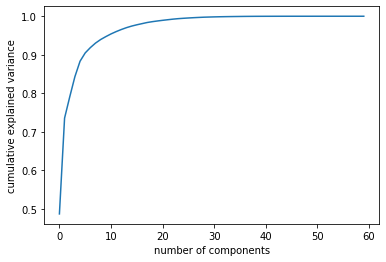

In [66]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [67]:
num_components = 40
pca = PCA(num_components)  
X_pca = pca.fit_transform(pwbds_m2) # fit and reduce dimension

In [68]:
X_pca.shape

(321, 40)

In [69]:
num_steps = 5 # Intervalo entre medições é de 2 minutos
x_new, y_new = lstm_data_transform(X_pca, yds_m2, num_steps=num_steps)
print ("The new shape of x is", x_new.shape)

The new shape of x is (317, 5, 40)


# Load Model

In [70]:
import tensorflow as tf
from keras.models import Sequential

In [71]:
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('../data/pwb_classification_multi')

# Verify the architecture 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional multiple                  154560    
_________________________________________________________________
batch_normalization (BatchNo multiple                  960       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  144480    
_________________________________________________________________
batch_normalization_1 (Batch multiple                  480       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  7

In [72]:
# make predictions and compute confusion matrix
#y_pred = model.predict_classes(x_test,verbose=1, batch_size=200)
y_pred = model.predict_classes(x_new)
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_new, y_pred)
cm

Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[  8,   0, 220],
       [  1,  16,  72],
       [  0,   0,   0]], dtype=int64)

In [74]:
# compute precision and recall
accuracy_test = accuracy_score(y_new, y_pred)
precision_test = precision_score(y_new, y_pred, average=None)
recall_test = recall_score(y_new, y_pred, average=None)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n', 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  0.07570977917981073 
 Test Precision:  [0.88888889 1.         0.        ] 
 Test Recall:  [0.03508772 0.17977528 0.        ] 
 Test F1 Score: [0.06751055 0.3047619         nan]


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide


In [75]:
np.unique(y_new,return_counts=True)

(array([0, 1]), array([228,  89], dtype=int64))

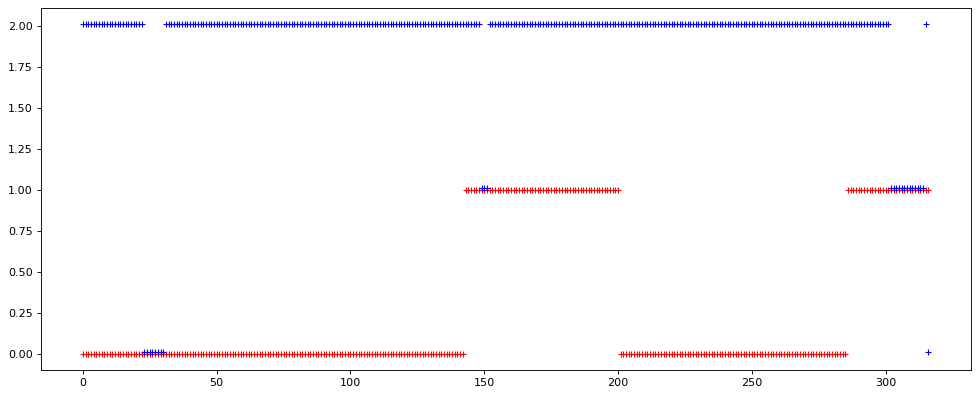

In [76]:
figure(figsize=(15, 6), dpi=80)
plt.plot(y_new,'r+')
plt.plot(y_pred+0.01,'b+')

In [77]:
import shap  # package used to calculate Shap values

# use Deep SHAP to explain test set predictions
#k_explainer = shap.KernelExplainer(model_1.predict_proba, x_test)
#k_shap_values = k_explainer.shap_values(x_test.reshape(14315*30,32))
#shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], x_test)

# Usando o Random Forest

In [102]:
import joblib
filename = '../data/pwb_classification_rf_multi'
# load the model from disk
clf_rf = joblib.load(filename)

In [103]:
X_pca.shape

(321, 40)

In [104]:
np.unique(Y,return_counts=True)

(array([0, 1, 2]), array([ 48,  41, 232], dtype=int64))

In [105]:
#y_pred_rf = cf_rf.predict_classes(x_new)
result_rf = clf_rf.score(X_pca, Y)
print(result_rf)

0.7227414330218068


In [106]:
y_pred = clf_rf.predict(X_pca)
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(Y, y_pred)
cm

Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[  0,   0,  48],
       [  0,   0,  41],
       [  0,   0, 232]], dtype=int64)

In [107]:
np.unique(y_pred,return_counts=True)

(array([2]), array([321], dtype=int64))

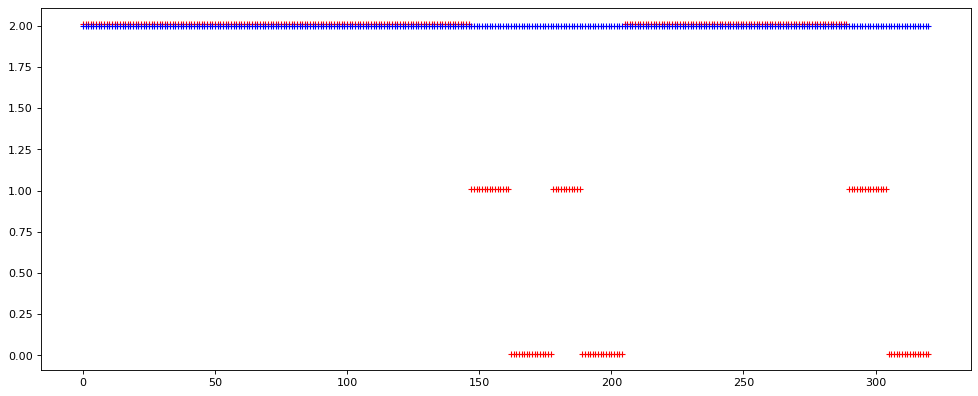

In [109]:
figure(figsize=(15, 6), dpi=80)
plt.plot(Y+0.01,'r+')
plt.plot(y_pred,'b+')

In [111]:
# compute precision and recall
accuracy_test = accuracy_score(Y, y_pred)
precision_test = precision_score(Y, y_pred,average=None)
recall_test = recall_score(Y, y_pred,average=None)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n', 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  0.7227414330218068 
 Test Precision:  [0.         0.         0.72274143] 
 Test Recall:  [0. 0. 1.] 
 Test F1 Score: [       nan        nan 0.83905967]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide


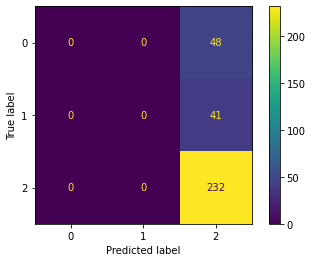

In [112]:
plot_confusion_matrix(cf_rf, X_pca, Y)

# Usando o XGBOOST

In [113]:
filename = '../data/pwb_classification_xgb_no_avalanche'
# load the model from disk
cf_xgb = joblib.load(filename)

In [114]:
y_pred = cf_xgb.predict(X_pca)
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(Y, y_pred)
cm

Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[ 36,  12,   0],
       [ 36,   5,   0],
       [172,  60,   0]], dtype=int64)

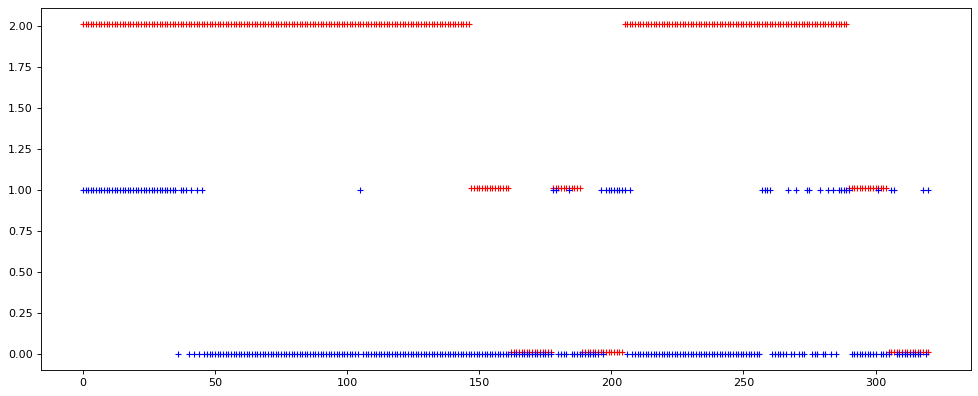

In [115]:
figure(figsize=(15, 6), dpi=80)
plt.plot(Y+0.01,'r+')
plt.plot(y_pred,'b+')

In [116]:
# compute precision and recall
accuracy_test = accuracy_score(Y, y_pred)
precision_test = precision_score(Y, y_pred,average=None)
recall_test = recall_score(Y, y_pred,average=None)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print('Test Accuracy: ', accuracy_test, '\n', 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)

Test Accuracy:  0.1277258566978193 
 Test Precision:  [0.14754098 0.06493506 0.        ] 
 Test Recall:  [0.75       0.12195122 0.        ] 
 Test F1 Score: [0.24657534 0.08474576        nan]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
invalid value encountered in true_divide


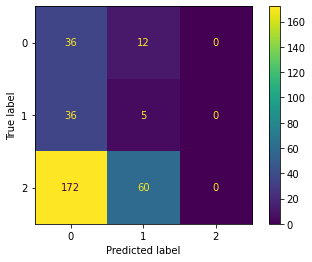

In [117]:
plot_confusion_matrix(cf_xgb, X_pca, Y)